In [1]:
# general imports
import pandas as pd
import numpy as np
import re
import json

In [2]:
# text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [123]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

In [4]:
data_directory = './pickles/dataframes'

## Loading data

Load all the data dataframes from json, they are raw uncleaned scrapped websites

In [5]:
all_recipe_df = pd.read_json(data_directory + '/all_recipe_raw.json')

In [6]:
food_com_df  = pd.read_json(data_directory + '/food_com_raw.json')

In [7]:
food_net_df  = pd.DataFrame(json.loads(open('./pickles/food_net.json').read()))

__NOTE__ : We will first clean each dataframe alone as each one of them contains different features.

## Cleaning  all_recipe.com 

In [8]:
all_recipe_df.head() # get glimpse of the data

,calories,cholesterol,cook_time,dietaryfiber,fat,name,prep_time,protein,rating,review,review_date,servings,sodium,total_time,totalcarbs
0,160,46mg,8M,4g,2.6g,Whole Wheat Blueberry Pancakes,5M,9.8g,4,I lost my 100% whole wheat pancake recipe and ...,"May 20, 2007",5,464mg,13M,26.7g
1,160,46mg,8M,4g,2.6g,Whole Wheat Blueberry Pancakes,5M,9.8g,4,Great recipe. Just add a bit more milk (or soy...,"Aug. 31, 2007",5,464mg,13M,26.7g
10,166,6mg,30M,0.2g,5.1g,Lemon Cooler Cream Cake,30M,2.4g,4,This has been a hit everytime I make it. My f...,"Jun. 22, 2009",24,256mg,1H,28.1g
100,906,104mg,30M,7.2g,47.5g,Fry Bread Tacos II,30M,40.5g,4,Five stars for the actual fry bread. I did ma...,"Jan. 12, 2008",4,2255mg,1H,76.7g
1000,462,135mg,20M,1g,36.5g,Creamy Chicken and Wild Rice Soup,5M,12g,4,Wonderful soup! This one really sticks to your...,"May 14, 2007",8,997mg,25M,22.6g


In [9]:
print("Number of recipes extracted = {}".format(all_recipe_df['name'].unique().shape[0]))

Number of recipes extracted = 9109


In [10]:
all_recipe_df.dtypes # get the data types of the columns in the data

calories         int64
cholesterol     object
cook_time       object
dietaryfiber    object
fat             object
name            object
prep_time       object
protein         object
rating           int64
review          object
review_date     object
servings         int64
sodium          object
total_time      object
totalcarbs      object
dtype: object

The first step of cleaning is to convert nutrition information having different scales into one scale. <br>
These include the columns:
1. cholesterol    
2. dietaryfiber
3. fat
4. protein
5. sodium
6. totalcarbs

In [11]:
cholesterol_scale = all_recipe_df['cholesterol'].str.replace('\d+','').unique()
dietary_scale     = all_recipe_df['dietaryfiber'].str.replace('\d+','').unique()
fat_scale         = all_recipe_df['fat'].str.replace('\d+','').unique()
protein_scale     = all_recipe_df['protein'].str.replace('\d+','').unique()
sodium_scale      = all_recipe_df['sodium'].str.replace('\d+','').unique()
carbs_scale       = all_recipe_df['totalcarbs'].str.replace('\d+','').unique()

In [12]:
scales_dict = {
    'cholesterol' : ' , '.join(cholesterol_scale),
    'dietary'     : ' , '.join(dietary_scale),
    'fat'         : ' , '.join(fat_scale),
    'protein'     : ' , '.join(protein_scale),
    'sodium'      : ' , '.join(sodium_scale),
    'carbs'       : ' , '.join(carbs_scale)
}

In [13]:
def render_dict_html(d):
    o = []
    for k, v in d.items():
        o.append('<tr><td>%s</td><td>%s</td></tr>' % (str(k), render_as_html(v)))
    return '<table>%s</table>' % ''.join(o)

def render_as_html(e):
    o = []
    if isinstance(e, list):
        o.append(render_list_html(e))
    elif isinstance(e, dict):
        o.append(render_dict_html(e))
    else:
        o.append(str(e))
    return '<html><body>%s</body></html>' % ''.join(o)

In [14]:
display(HTML(render_as_html(scales_dict)))

carbs,".g , g"
sodium,"mg , < mg"
fat,".g , g"
dietary,"g , .g"
cholesterol,"mg , < mg"
protein,".g , g"


From the above table all scales are the same per column and thus we just need to remove these strings from the columns and convert to integer

In [15]:
all_recipe_df['cholesterol']  = all_recipe_df['cholesterol'].str.extract('(\d+)').astype(int)
all_recipe_df['dietaryfiber'] = all_recipe_df['dietaryfiber'].str.extract('(\d+)').astype(int)
all_recipe_df['fat']          = all_recipe_df['fat'].str.extract('(\d+)').astype(int)
all_recipe_df['protein']      = all_recipe_df['protein'].str.extract('(\d+)').astype(int)
all_recipe_df['sodium']       = all_recipe_df['sodium'].str.extract('(\d+)').astype(int)
all_recipe_df['totalcarbs']   = all_recipe_df['totalcarbs'].str.extract('(\d+)').astype(int)

In [16]:
all_recipe_df.dtypes # to verify the data types and check that they are numeric

calories         int64
cholesterol      int64
cook_time       object
dietaryfiber     int64
fat              int64
name            object
prep_time       object
protein          int64
rating           int64
review          object
review_date     object
servings         int64
sodium           int64
total_time      object
totalcarbs       int64
dtype: object

The next step is to clean the time and date columns and extract usefull information from them. <br>
These columns include:
1. prep_time   : total time to prepare the ingredients of the recipe to be cooked
2. cook_time   : total time to be spent to cook the meal
3. total_time  : total time to cook a recipe
4. review_date : the date which the review of the recipe is given

In [17]:
all_recipe_df['prep_time'].str.replace('\d+','').unique()

array([u'M', nan, u'HM', u'H', u'DayH', u'DaysH', u'DaysHM', u'Day'],
      dtype=object)

In [18]:
all_recipe_df['cook_time'].str.replace('\d+','').unique()

array([u'M', nan, u'H', u'HM', u'DaysH', u'DayH', u'Day'], dtype=object)

In [19]:
all_recipe_df['total_time'].str.replace('\d+','').unique()

array([u'M', u'H', nan, u'HM', u'DayM', u'DayH', u'DaysM', u'DaysHM',
       u'DayHM', u'DaysH', u'Days', u'Day'], dtype=object)

We can see from the above that all these 3 columns have different scales. The next step is to rescale all of them down to minute scale as it is the smallest among them. <br>
A small explanation of the scales:
1. M    : kept the same value
2. H    : each value is multiplied by 60
3. Day/Days  : each value is multiplied by 3600
<br>

You can see that these values in the presented scales are appended to each other since they are seperated by the digits. For the nan value no scale was presented.

In [20]:
scale = ['Day','H','M']

In [21]:
def rescale_time(meal_time,scale):
    
    if isinstance(meal_time,int):
        return meal_time
    else:
    
        if 's' in meal_time:
            meal_time = meal_time.replace('s','')

        total_time = 0
        for i in range(0,len(scale)):
            
            res = meal_time.split(scale[i])
            if res[0] == meal_time:
                continue
            else:
                meal_time = res[1]
                if scale[i] == 'Day':
                    cnst = 3600
                elif scale[i] == 'H':
                    cnst = 60
                elif scale[i] == 'M':
                    cnst = 1

                total_time += (int(res[0]) * cnst)


        return total_time
    

In [22]:
all_recipe_df['prep_time']  = all_recipe_df['prep_time'].apply(lambda x : rescale_time(x,scale))
all_recipe_df['cook_time']  = all_recipe_df['cook_time'].apply(lambda x : rescale_time(x,scale))
all_recipe_df['total_time'] = all_recipe_df['total_time'].apply(lambda x : rescale_time(x,scale))

Now for month data we just need to extract three features days,month and year. We perform this by adding these columns by extracting the needed info.

In [23]:
month_mapping = dict({'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12})

In [24]:
def extract_month(date,month_scale):
    dates_split = date.replace(',','').replace('.','').split(' ')
    return month_scale[dates_split[0]]

In [25]:
def extract_day(date):
    dates_split = date.replace(',','').replace('.','').split(' ')
    return dates_split[1]

In [26]:
def extract_year(date):
    dates_split = date.replace(',','').replace('.','').split(' ')
    return dates_split[2]

In [27]:
all_recipe_df['day'] = all_recipe_df['review_date'].apply(lambda x : extract_day(x)).astype(int)
all_recipe_df['month'] = all_recipe_df['review_date'].apply(lambda x : extract_month(x,month_mapping)).astype(int)
all_recipe_df['year'] = all_recipe_df['review_date'].apply(lambda x : extract_year(x)).astype(int)
all_recipe_df = all_recipe_df.drop('review_date',axis=1)

In [28]:
all_recipe_df.dtypes # verify results

calories         int64
cholesterol      int64
cook_time        int64
dietaryfiber     int64
fat              int64
name            object
prep_time        int64
protein          int64
rating           int64
review          object
servings         int64
sodium           int64
total_time       int64
totalcarbs       int64
day              int64
month            int64
year             int64
dtype: object

For the last step before starting with the NLP part. We need to change the review into categorical data corresponding to the sentiment of the reviewer. These will fall into 3 buckets:
1. A rating of 1 and 2 will be considered as negative and equal to 0.
2. A rating of 3 will be considered as neutral and equal to 1.
3. A rating of 4 and 5 will be considered as positive and equal to 2.

In [29]:
review_buckets = {1:0,2:0,3:1,4:2,5:2}
all_recipe_df['rating'] = all_recipe_df['rating'].apply(lambda x : review_buckets[x])

In [30]:
all_recipe_df.head()

,calories,cholesterol,cook_time,dietaryfiber,fat,name,prep_time,protein,rating,review,servings,sodium,total_time,totalcarbs,day,month,year
0,160,46,8,4,2,Whole Wheat Blueberry Pancakes,5,9,2,I lost my 100% whole wheat pancake recipe and ...,5,464,13,26,20,5,2007
1,160,46,8,4,2,Whole Wheat Blueberry Pancakes,5,9,2,Great recipe. Just add a bit more milk (or soy...,5,464,13,26,31,8,2007
10,166,6,30,0,5,Lemon Cooler Cream Cake,30,2,2,This has been a hit everytime I make it. My f...,24,256,60,28,22,6,2009
100,906,104,30,7,47,Fry Bread Tacos II,30,40,2,Five stars for the actual fry bread. I did ma...,4,2255,60,76,12,1,2008
1000,462,135,20,1,36,Creamy Chicken and Wild Rice Soup,5,12,2,Wonderful soup! This one really sticks to your...,8,997,25,22,14,5,2007


## Working with text

The text pipline cleaning goes as follows:
1. load the reviews from the dataframe
2. remove non alphabetic letters
3. convert letters to lowercase (this helps us to increase the number of words that are common)
4. remove stopwords as they don't give us much semantic meaning
5. lemmatizing words helps us removing prefixes and affixes and thus increasing the similarity of the words
6. Finally we construct a document term matrix using both (tf-idf and one-hot encoding) matrices

In [31]:
reviews_per_recipe = all_recipe_df['review'].values # load the reviews

In [32]:
def remove_non_chars(input_reviews):
    return np.array( [re.sub('[^a-zA-Z]+',' ',sample) for sample in input_reviews])

In [33]:
def lowercase(input_reviews):
    # convert all words to lower case letters
    return np.array( [' '.join([word.lower() for word in sample.split()]) for sample in input_reviews])

In [34]:
def remove_stopwords(input_reviews):
    # removes stop words
    stop = stopwords.words('english')
    return np.array( [' '.join([word for word in sample.split() if word.lower() not in stop]) for sample in input_reviews])

In [35]:
def lemmatize_words(input_reviews):
    # removes affixes and prefixes
    lem = WordNetLemmatizer()
    return np.array( [' '.join([lem.lemmatize(word) for word in sample.split()]) for sample in input_reviews])

In [36]:
review_non_char  = remove_non_chars(reviews_per_recipe)
review_lowercase = lowercase(review_non_char)
review_not_stop  = remove_stopwords(review_lowercase)
review_lemmas    = lemmatize_words(review_not_stop)

In [37]:
tfidf_vectorizer = TfidfVectorizer(max_df=2)
count_vectorizer = CountVectorizer(max_df=2)
X1 = tfidf_vectorizer.fit_transform(review_lemmas)
X2 = count_vectorizer.fit_transform(review_lemmas)

In [38]:
tfidf_df = pd.DataFrame(X1.toarray(), columns=tfidf_vectorizer.get_feature_names())
count_df = pd.DataFrame(X2.toarray(), columns=count_vectorizer.get_feature_names())

In [39]:
tfidf_df['recipe_name'] = all_recipe_df['name'].values
count_df['recipe_name'] = all_recipe_df['name'].values

In [ ]:
# final datasets
all_recipe_df,tfidf_df,count_df

## Cleaning Food.com

In [40]:
food_com_df.dtypes

calories                      float64
carbohydrateContent           float64
category                       object
cholesterolContent            float64
cookTime                       object
date                   datetime64[ns]
fatContent                    float64
fiberContent                  float64
name                           object
prepTime                       object
proteinContent                float64
review                         object
review_date                    object
saturatedFatContent           float64
servings                       object
sodiumContent                 float64
sugarContent                  float64
dtype: object

In [41]:
print("Number of recipes extracted = {}".format(food_com_df['name'].unique().shape[0]))

Number of recipes extracted = 8507


To do the processing again we start by cleaning nutrition data, however in this case all data is in numeric format with no scales given (thus no need for parsing anything)

Moving to the next step would be cleaning data related to time and dates. The only additional column in comparison with the previous dataframe is that in this dataset we have the date in which the user gave a review.

In [42]:
cook_scale = food_com_df['cookTime'].str.replace('\d+','').unique()
prep_scale = food_com_df['prepTime'].str.replace('\d+','').unique()
cook_scale,prep_scale

(array([u' mins', u' hrs ', u' hrs  mins'], dtype=object),
 array([u' mins', u' hrs  mins', u' hrs '], dtype=object))

In [43]:
def rescale_time(input_time,time_scale=['hrs','mins']):
    
    input_time = input_time.strip()
    total_time = 0
    for i in range(0,len(time_scale)):
        res = input_time.split(time_scale[i])
        if res[0] == input_time:
            continue
        else:
            input_time = input_time[1]
            if time_scale[i] == 'hrs':
                cnst = 60
            elif time_scale[i] == 'mins':
                cnst = 1
            total_time += (int(res[0]) * cnst)
            
    return total_time
        

In [44]:
food_com_df['prepTime'] = food_com_df['prepTime'].apply(lambda x : rescale_time(x)).astype(int)
food_com_df['cookTime'] = food_com_df['cookTime'].apply(lambda x : rescale_time(x)).astype(int)

Moving on to date data we do as we did in the first step : extract month,day and year and construct columns out of them.

In [45]:
food_month_map = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,
                  'October':10,'November':11,'December':12}

In [46]:
def extract_month_food(time,month_mapping):
    extract_month = time.split(' ')[0]
    return month_mapping[extract_month]

In [47]:
def extract_day_food(time):
    return int(time.split(' ')[1].replace(',',''))

In [48]:
def extract_year_food(time):
    return int(time.split(',')[1])

In [49]:
food_com_df['review_day']   = food_com_df['review_date'].apply(lambda x: extract_day_food(x))
food_com_df['review_month'] = food_com_df['review_date'].apply(lambda x: extract_month_food(x,food_month_map))
food_com_df['review_year']  = food_com_df['review_date'].apply(lambda x: extract_year_food(x))

In [50]:
food_com_df['post_day'] = food_com_df['date'].map(lambda x: x.day)
food_com_df['post_month'] = food_com_df['date'].map(lambda x: x.month)
food_com_df['post_year'] = food_com_df['date'].map(lambda x: x.year)

Fix servings column as they are not integers.

In [51]:
def parse_floats(input_serving):
    
    if '/' in input_serving: # if data contains a fraction
        res = input_serving.split('/')
        temp = res[0].split(' ')
        if len(temp)>1:
            return float(temp[0]) + (float(temp[1])/float(res[1]))
        else:
            return float(temp[0])/float(res[1])
        
    else:
        return float(input_serving)

In [52]:
food_com_df['servings'] = food_com_df['servings'].apply(lambda x : parse_floats(x))

Apply text pipline for this dataset again.

In [53]:
reviews_per_recipe_food_com = food_com_df['review'].values

In [54]:
review_foodcom_non_char  = remove_non_chars(reviews_per_recipe_food_com)
review_foodcom_lowercase = lowercase(review_foodcom_non_char)
review_foodcom_not_stop  = remove_stopwords(review_foodcom_lowercase)
review_foodcom_lemmas    = lemmatize_words(review_foodcom_not_stop)

In [55]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8)
count_vectorizer = CountVectorizer(max_df=0.8)
X3 = tfidf_vectorizer.fit_transform(review_foodcom_lemmas)
X4 = count_vectorizer.fit_transform(review_foodcom_lemmas)

In [56]:
tfidf_foodcom_df = pd.DataFrame(X3.toarray(), columns=tfidf_vectorizer.get_feature_names())
count_foodcom_df = pd.DataFrame(X4.toarray(), columns=count_vectorizer.get_feature_names())

In [57]:
tfidf_foodcom_df['recipe_name'] = food_com_df['name'].values
count_foodcom_df['recipe_name'] = food_com_df['name'].values

In [ ]:
# final datasets
food_com_df,tfidf_foodcom_df,count_foodcom_df

## Cleaning food_net.com 

In [58]:
food_net_df.head() # get glimpse of data

,category,cook_time,difficulty,name,prep_time,rating,review,review_date
0,"[Pizza, European, Italian, Baking, Fall, Sprin...",30,Intermediate,Basic Pizza Dough - By Hand Method,5,4,"Followed recipe and instructions, Dough was 's...","December 06, 2011"
1,[],30,Intermediate,Basic Pizza Dough - By Hand Method,5,4,If your a person who likes those thick crust p...,"November 22, 2009"
2,[],30,Intermediate,Basic Pizza Dough - By Hand Method,5,4,The first time i was making pizza i used this ...,"April 29, 2007"
3,"[Cookie, For a Crowd]",10,Easy,Pineapple Cookies,15,2,it left a lot to be desired..my daughter said ...,"October 09, 2011"
4,[],10,Easy,Pineapple Cookies,15,2,what taste? there was no taste. ours went into...,"March 21, 2011"


In [60]:
print("Recipies extracted from food_net.com = {}".format(food_net_df['name'].unique().shape[0]))

Recipies extracted from food_net.com = 1827


In [59]:
food_net_df.dtypes

category       object
cook_time      object
difficulty     object
name           object
prep_time      object
rating          int64
review         object
review_date    object
dtype: object

The first thing to do is to convert time related columns into integers as there is no scale as observed in the first dataframe.

In [61]:
food_net_df['cook_time'] = food_net_df['cook_time'].astype(int)

In [62]:
food_net_df['prep_time'] = food_net_df['prep_time'].astype(int)

Next step is to change the difficulty level into a dummy encoding as it makes it easier to use in the analyis.

In [63]:
diff_dummy = pd.get_dummies(food_net_df['difficulty'])
food_net_df = food_net_df.drop('difficulty',axis = 1)
food_net_df = pd.concat((food_net_df,diff_dummy),axis=1)

A step which we did previously was to put different ratings into different buckets,the same step is applied again here.

In [64]:
review_buckets = {1:0,2:0,3:1,4:2,5:2}
food_net_df['rating'] = food_net_df['rating'].apply(lambda x : review_buckets[x])

Now we extract date related features, such as extract day,month and year columns

In [65]:
def parse_rev_day(input_date):
    values = input_date.replace(',','')
    values = values.split(' ')
    return int(values[2])

In [66]:
def parse_rev_month(input_date):
    values = input_date.replace(',','')
    values = values.split(' ')
    return food_month_map[values[1]]

In [67]:
def parse_rev_year(input_date):
    values = input_date.replace(',','')
    values = values.split(' ')
    return values[3]

In [68]:
# there was a row which was parsed in a wrong manner having text instead of date information
validity = food_net_df['review_date'].values
rows_drop = []
for i in range(0,validity.shape[0]):
    check_validity = re.findall('\d+',validity[i])
    if len(check_validity) == 0:
        rows_drop.append(i)
food_net_df = food_net_df.drop(rows_drop,axis=0)

In [69]:
food_net_df['day']   = food_net_df['review_date'].apply(lambda x : parse_rev_day(x)).astype(int)
food_net_df['month'] = food_net_df['review_date'].apply(lambda x : parse_rev_month(x)).astype(int)
food_net_df['year']  = food_net_df['review_date'].apply(lambda x : parse_rev_year(x)).astype(int)

In [70]:
food_net_df.head()

,category,cook_time,name,prep_time,rating,review,review_date,--,Difficult,Easy,Intermediate,day,month,year
0,"[Pizza, European, Italian, Baking, Fall, Sprin...",30,Basic Pizza Dough - By Hand Method,5,2,"Followed recipe and instructions, Dough was 's...","December 06, 2011",0,0,0,1,6,12,2011
1,[],30,Basic Pizza Dough - By Hand Method,5,2,If your a person who likes those thick crust p...,"November 22, 2009",0,0,0,1,22,11,2009
2,[],30,Basic Pizza Dough - By Hand Method,5,2,The first time i was making pizza i used this ...,"April 29, 2007",0,0,0,1,29,4,2007
3,"[Cookie, For a Crowd]",10,Pineapple Cookies,15,0,it left a lot to be desired..my daughter said ...,"October 09, 2011",0,0,1,0,9,10,2011
4,[],10,Pineapple Cookies,15,0,what taste? there was no taste. ours went into...,"March 21, 2011",0,0,1,0,21,3,2011


Now we apply the NLP pipeline again here.

In [71]:
reviews_per_recipe_food_net = food_net_df['review'].values

In [72]:
review_foodnet_non_char  = remove_non_chars(reviews_per_recipe_food_net)
review_foodnet_lowercase = lowercase(review_foodnet_non_char)
review_foodnet_not_stop  = remove_stopwords(review_foodnet_lowercase)
review_foodnet_lemmas    = lemmatize_words(review_foodnet_not_stop)

In [73]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8)
count_vectorizer = CountVectorizer(max_df=0.8)
X5 = tfidf_vectorizer.fit_transform(review_foodnet_lemmas)
X6 = count_vectorizer.fit_transform(review_foodnet_lemmas)

In [74]:
tfidf_foodnet_df = pd.DataFrame(X5.toarray(), columns=tfidf_vectorizer.get_feature_names())
count_foodnet_df = pd.DataFrame(X6.toarray(), columns=count_vectorizer.get_feature_names())

In [75]:
tfidf_foodnet_df['recipe_name'] = food_net_df['name'].values
count_foodnet_df['recipe_name'] = food_net_df['name'].values

In [ ]:
# final datasets
food_com_df,tfidf_foodcom_df,count_foodcom_df

# Visualizations

In this section we aim to have a small overview of how the data looks like,mainy the factors which we suspect that might effect the rating of the user.

The challenge currently is that different websites contain different aspects of the recipe information and thus this would be a challenge for the next milestone is to see wether to integrate all data together or keep them seperate.
Please refer to the github readme for further details.

__NOTE__ : please note that all of our dataframes have a review per row and thus we always perform a groupby on the recipe name accumilate the info needed then display the plot.

### 1. Ratings distribution

It is important to study the distribution of the recipe data as this indicator will help us label the dataset and thus understand the sentiment of the user. If the user has rated the recipe with a score of 2 then the user has a positive sentiment. If the rating is equal to 1 then the user is neutral neither likes nor dislikes. If the score is zero then this implies a dislike from the user.

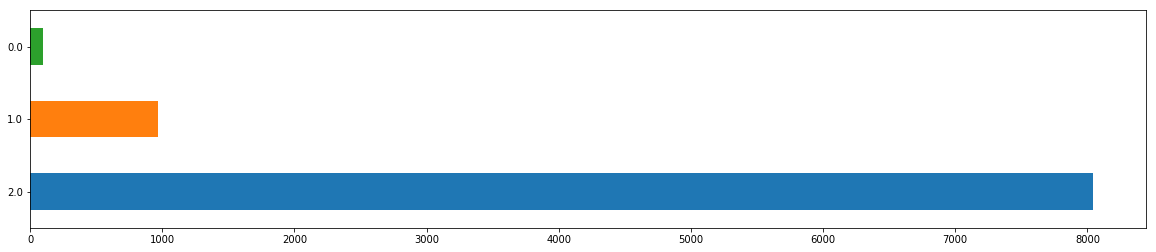

In [82]:
rating_subset = all_recipe_df[['name','rating']]
rating_per_recipe = rating_subset.groupby(['name']).mean().round()
rating_per_recipe['rating'].value_counts().plot(kind='barh', figsize=(20,4))

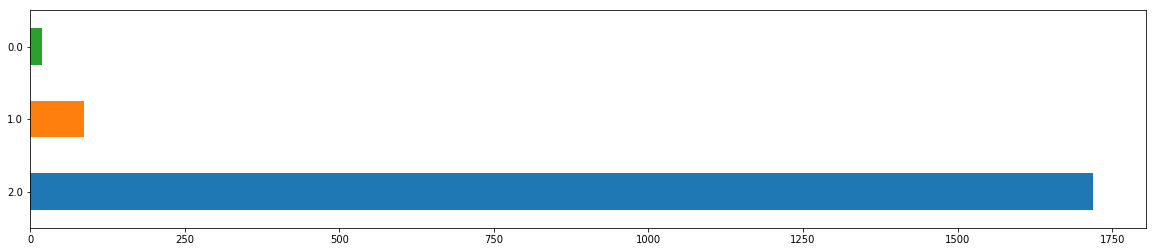

In [84]:
rating_subset = food_net_df[['name','rating']]
rating_per_recipe = rating_subset.groupby(['name']).mean().round()
rating_per_recipe['rating'].value_counts().plot(kind='barh', figsize=(20,4))

From the above plots we can observe that the All recipe website and food network webiste have imbalanced datasets.Most of the people gave a high overall score of the recipe. Thus we need to handle this imbalance of the data using over and under sampling in our analysis.

### 2. Number of servings distribution

The importance of anlayzing the distribution of the meal sizes is to see wether chefs target a more individual level or more familly sized meals. This can be a factor to attract the user in reading the meal recipe.

In [91]:
all_recipe_servings = all_recipe_df[['name','servings']]
food_com_servings = food_com_df[['name','servings']]

In [95]:
all_recipe_servings = all_recipe_servings.groupby(['name']).mean().round()
food_com_servings   = food_com_servings.groupby(['name']).mean().round()

In [96]:
all_recipe_servings.describe()

,servings
count,9109.000000
mean,12.038424
std,13.611446
min,1.000000
25%,6.000000
50%,8.000000
75%,12.000000
max,240.000000


In [97]:
food_com_servings.describe()

,servings
count,8507.000000
mean,7.849536
std,10.477734
min,0.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,300.000000


Serving values range have a large sparse range as seen in both datasets, hence we will plot data that resides between the 0 and 50 people which seems to be a logical range for serving people

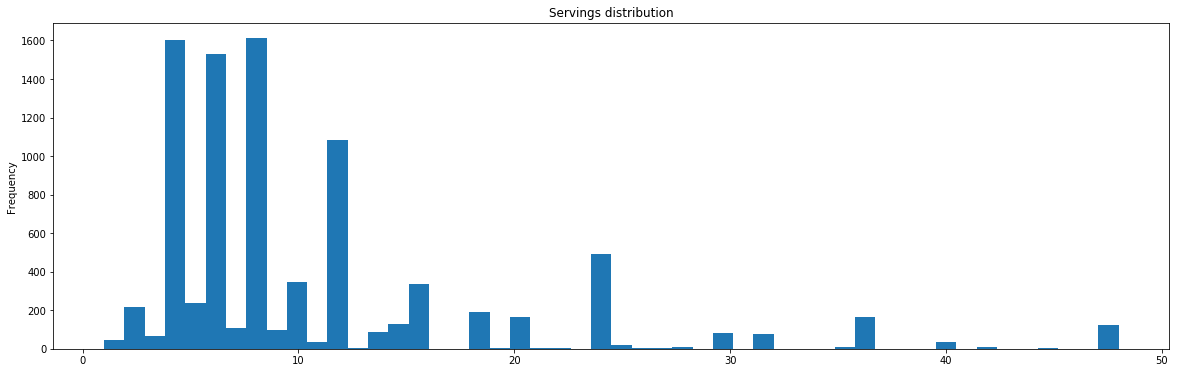

In [100]:
servings = all_recipe_servings[(all_recipe_servings['servings'] >= 0) & (all_recipe_servings['servings'] < 50)]
servings['servings'].plot(kind='hist', bins=50, figsize=(20,6), title='Servings distribution')

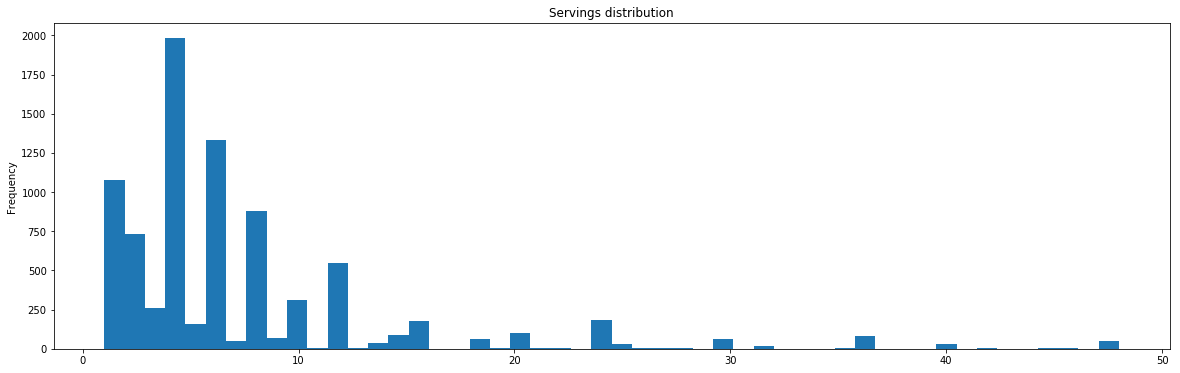

In [101]:
servings = food_com_servings[(food_com_servings['servings'] > 0) & (food_com_servings['servings'] < 50)]
servings['servings'].plot(kind='hist', bins=50, figsize=(20,6), title='Servings distribution')

From both datasets we can clearly observe that the bulk of the data resides between 1 and 10 people to be served. This makes it logical as the websites tend to target meals supported for individuals,couples,families and gatherings.

### 3. The distribution of reviews over time

Analyzing time is a good factor to infer wether there is a trend of people reading about food more often in the latest years or relying on ready made food.

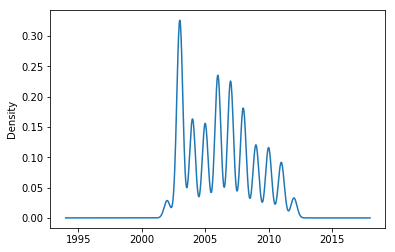

In [107]:
all_recipe_df.year.plot.density()

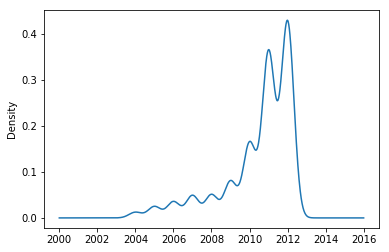

In [108]:
food_net_df.year.plot.density()

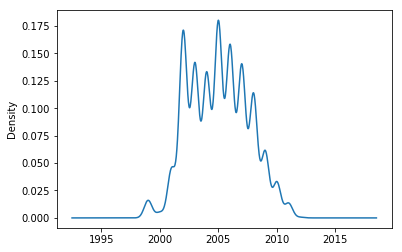

In [109]:
food_com_df.post_year.plot.density()

From the plots above we see how many ratings were submitted over the years. Highest density is reached between 2000 and 2010 for all 3 datasets. This can be contributed to the fact that data which the dump was collected in.The trend  differs between websites:
1. For all recipes website people gave less reviews over time
2. For food.com website there is an increase of intreset in reviewing other people
3. For food network website people are active throughout the years

### 4. Nutrition vs. Ratings

For this section we would like to observe the correlation between different nutritional components and their relation with the rating of the meal.

In [124]:
cols = [u'name',u'calories',u'cholesterol',u'dietaryfiber',u'fat',u'protein',u'sodium',u'totalcarbs',u'rating']
all_recipe_nutrition = all_recipe_df[cols]

In [125]:
all_recipe_nutrition = all_recipe_nutrition.groupby(['name']).mean().round()

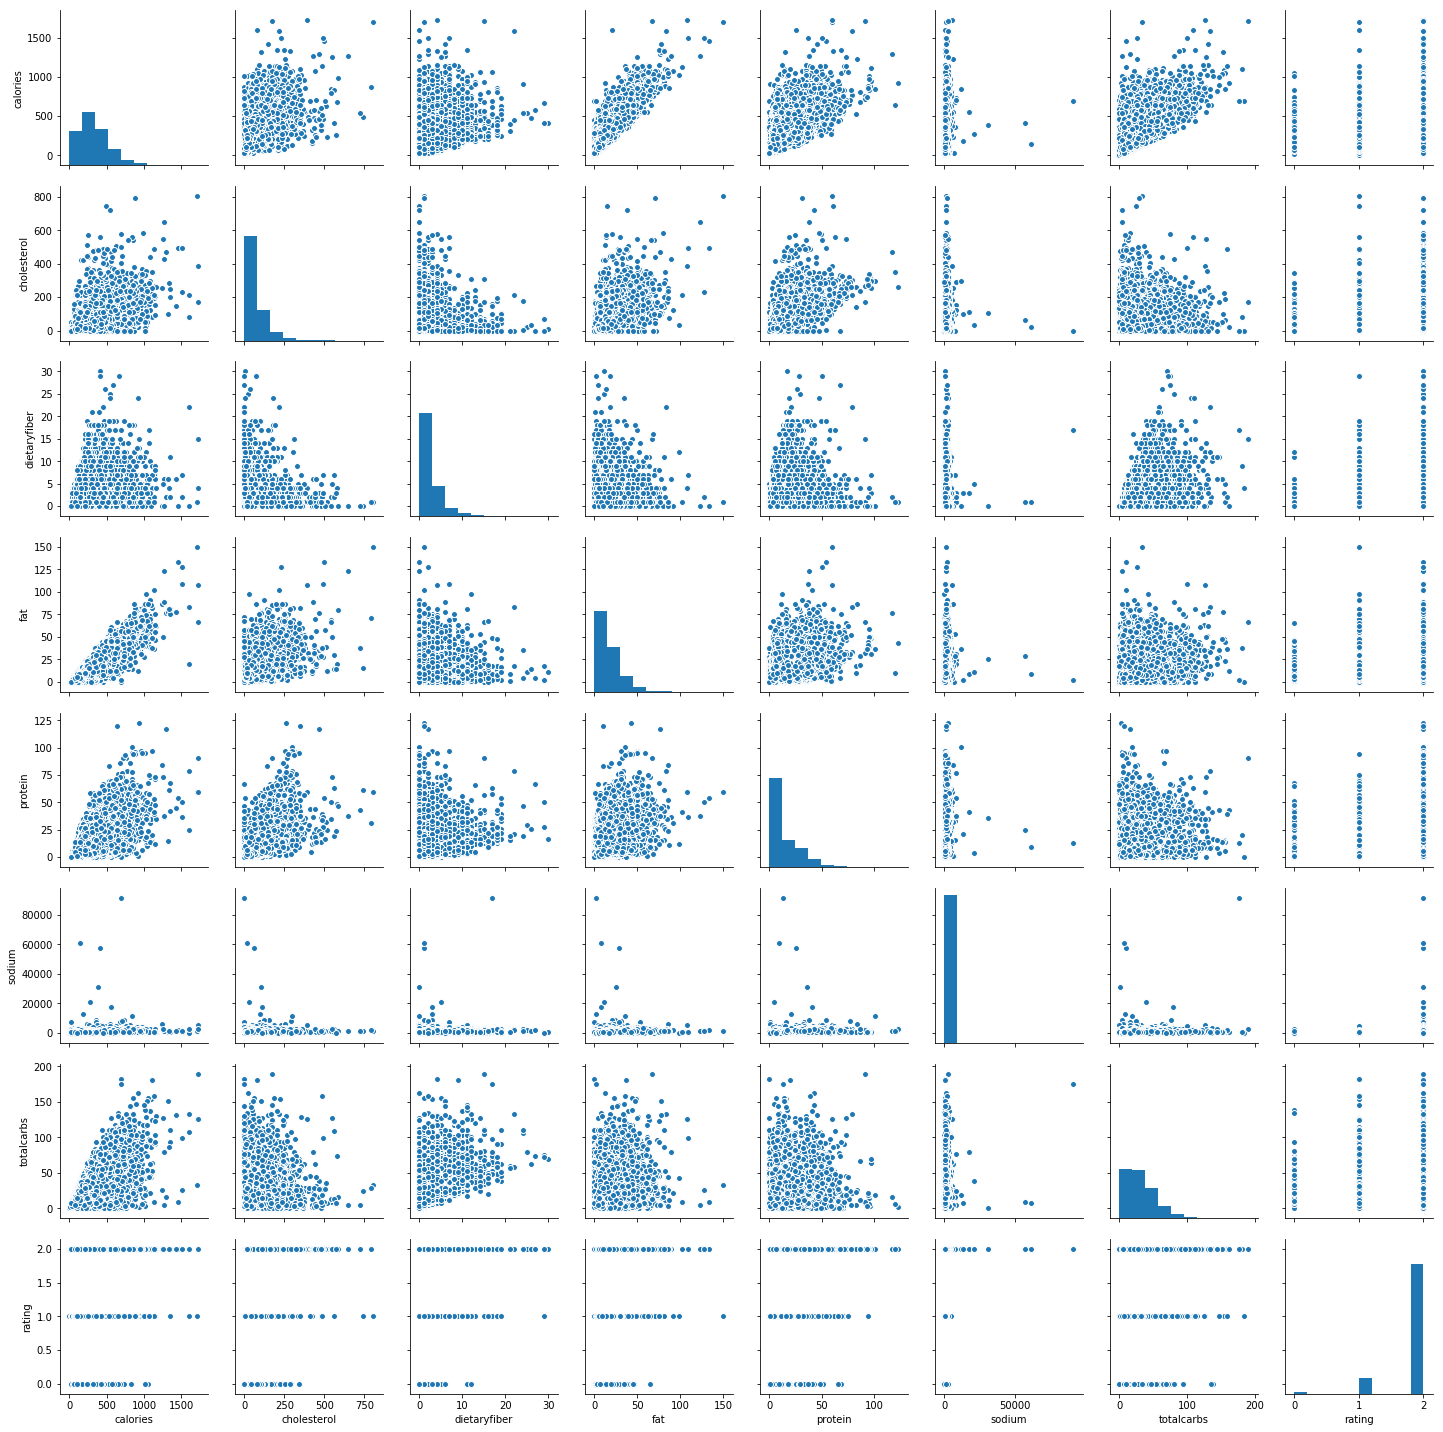

In [126]:
sns.pairplot(all_recipe_nutrition)

From the plot above, if we consider the last row, we can observe there is no clear correlation bertween the ratings and the nutritional components of the recipe.

### 5. Time for cooking the meal

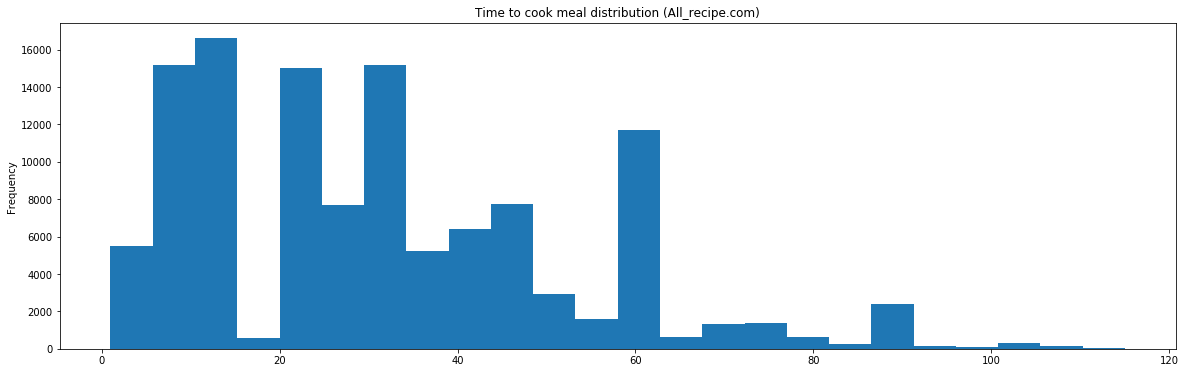

In [142]:
cook_time = all_recipe_df[(all_recipe_df['cook_time'] > 0) & (all_recipe_df['cook_time'] < 120)]
cook_time['cook_time'].plot(kind='hist', bins=24, figsize=(20,6),title='Time to cook meal distribution (All_recipe.com)')

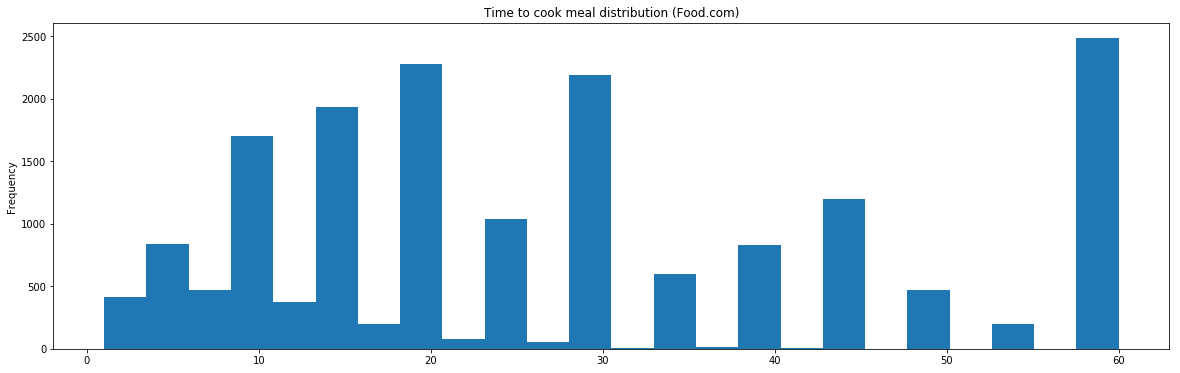

In [145]:
cook_time = food_com_df[(food_com_df['cookTime'] > 0) & (food_com_df['cookTime'] < 120)]
cook_time['cookTime'].plot(kind='hist', bins=24, figsize=(20,6),title='Time to cook meal distribution (Food.com)')

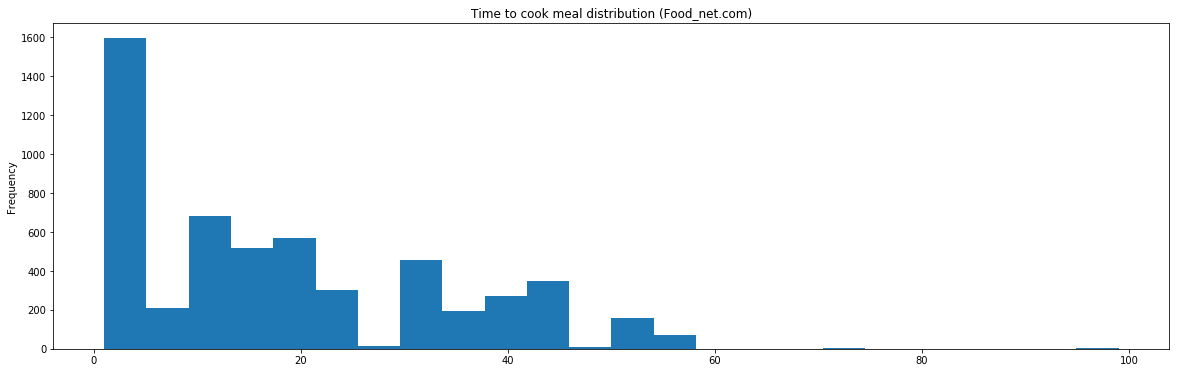

In [146]:
cook_time = food_net_df[(food_net_df['cook_time'] > 0) & (food_net_df['cook_time'] < 120)]
cook_time['cook_time'].plot(kind='hist', bins=24, figsize=(20,6),title='Time to cook meal distribution (Food_net.com)')

We can infer from the plots above that the data is focused between 2 min to an hour of cooking.